In [1]:
# Prepare the notebook to be able to import external code files
%load_ext autoreload
%autoreload 2
%matplotlib inline
import sys, os

currDir = os.path.realpath(".")
rootDir = os.path.abspath(os.path.join(currDir, ".."))
sys.path.insert(0, rootDir + '/src/')

## Load test images

In [2]:
import matplotlib.pyplot as plt
from lanelines.io import load_image

fnames = ["straight_lines1.jpg",
          "straight_lines2.jpg",
          "test2.jpg", 
          "test3.jpg",
          "test4.jpg", 
          "test5.jpg",
          "test6.jpg"]

test_imgs = [load_image(fname) for fname in fnames]

init


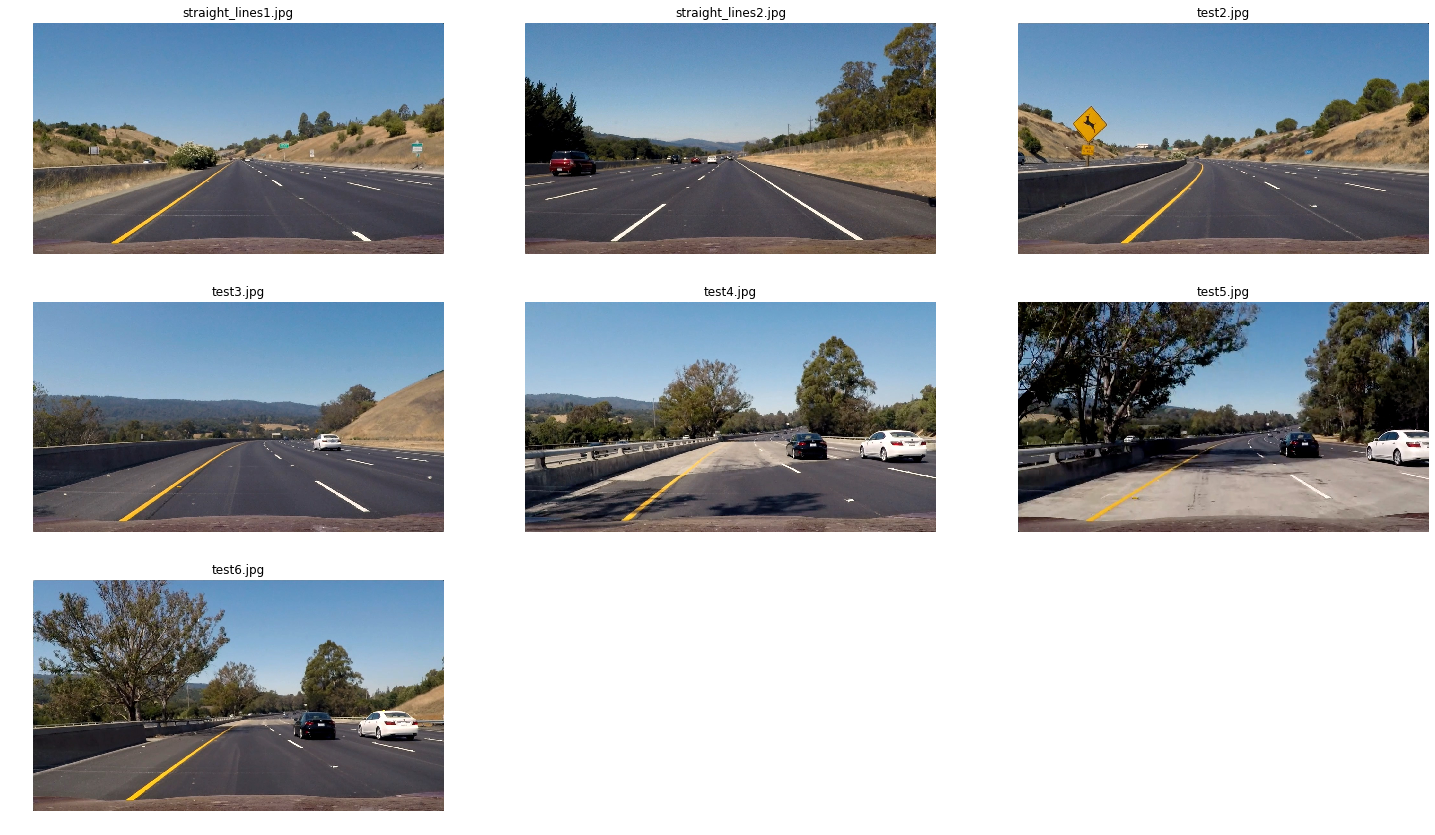

In [3]:
fig = plt.figure(figsize=(25,35))
fig.tight_layout() 
for i in range(len(test_imgs)):
    plt.subplot(len(test_imgs),3,i+1), plt.axis("off"), plt.imshow(test_imgs[i]), plt.title(fnames[i])

## Undistortion

In [4]:
from lanelines.preprocessing import DistortionCorrector

dist_cor = DistortionCorrector()
calib = dist_cor.fit()

Successfully calibrated DistortionCorrector.


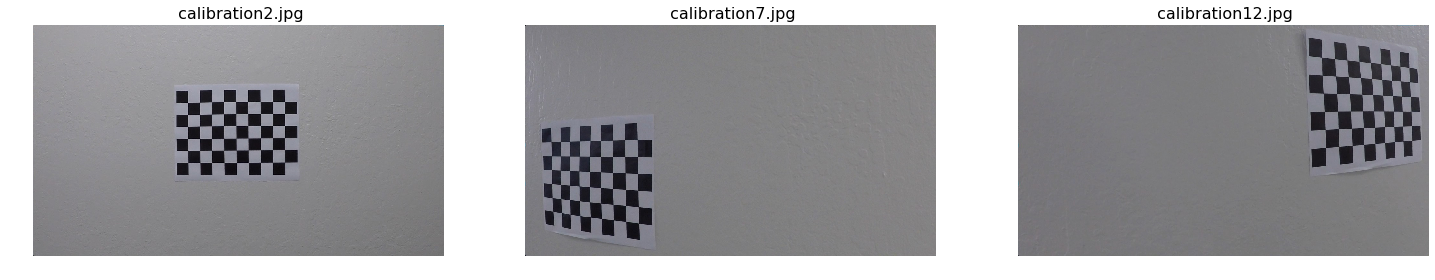

In [5]:
from lanelines.io import camera_calibration_files, load_image, plot_images
import numpy as np
import cv2

c = [cv2.cvtColor(cv2.imread(i), cv2.COLOR_BGR2RGB) for i in camera_calibration_files()]

plot_images(["", "", ""], ["calibration2.jpg", "calibration7.jpg", "calibration12.jpg"], [c[2]], [c[7]], [c[12]])

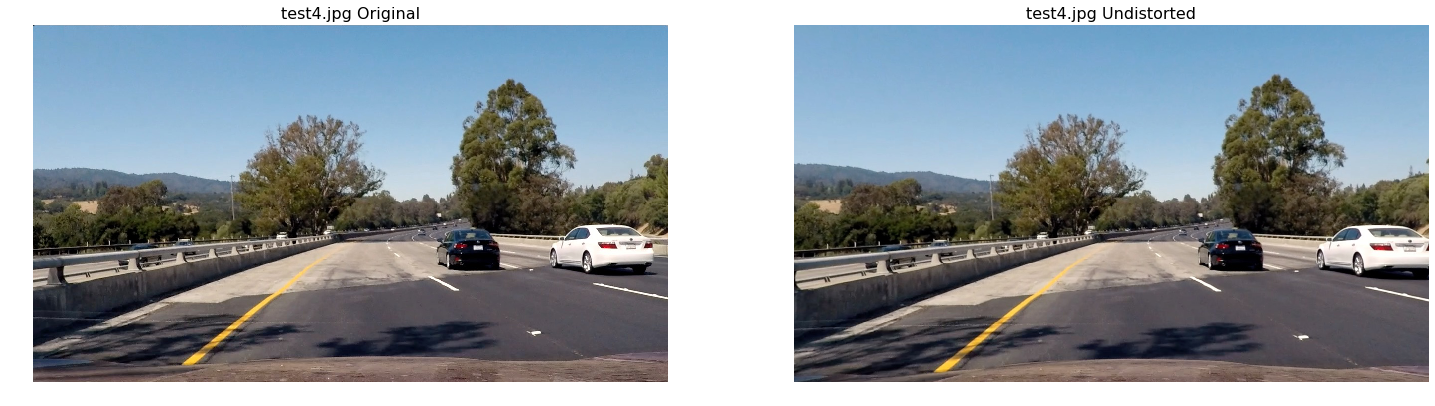

In [6]:
from lanelines.io import plot_images

undistorted_imgs = [dist_cor.transform(img) for img in test_imgs]
plot_images(fnames[4:5], ["Original", "Undistorted"], test_imgs[4:5], undistorted_imgs[4:5])

## Binary Thresholded Images

### Color filtering

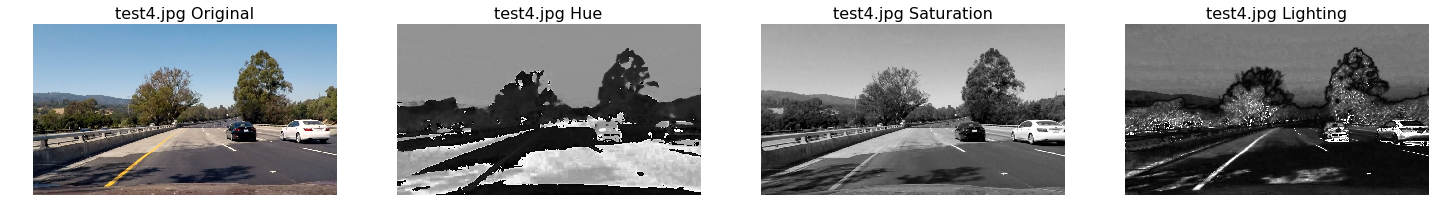

In [7]:
from lanelines.preprocessing import hls

hls = [hls(img) for img in undistorted_imgs]
h_imgs, l_imgs, s_imgs = zip(*hls)
plot_images(fnames[4:5], ["Original", "Hue", "Saturation", "Lighting"], test_imgs[4:5], h_imgs[4:5], l_imgs[4:5], s_imgs[4:5])

Create a white and a yellow filtered version of the image.

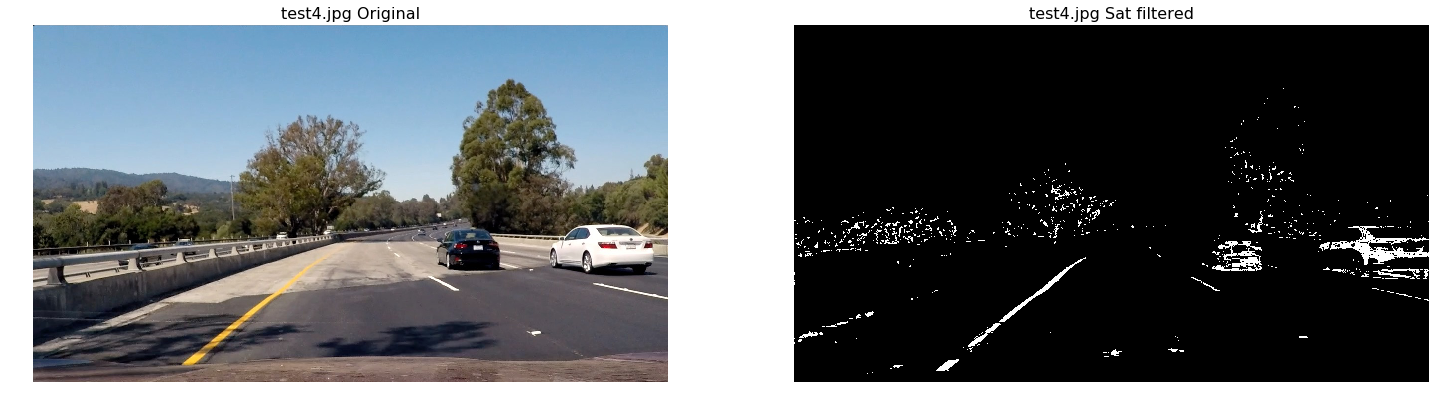

In [8]:
from lanelines.preprocessing import threshold
import cv2

s_imgs_thrsh = [threshold(img, thresh=[170, 255]) for img in s_imgs]
plot_images(fnames[4:5], ["Original", "Sat filtered"], test_imgs[4:5], s_imgs_thrsh[4:5])

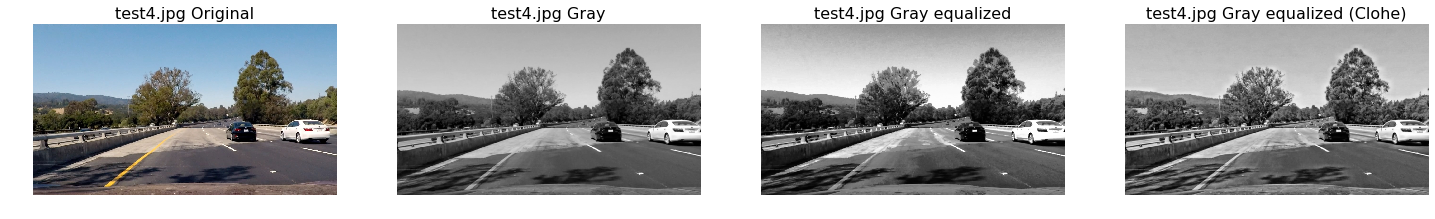

In [10]:
import cv2
from lanelines.preprocessing import gray
clahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(40,40))

imgs_gray0 = [cv2.GaussianBlur(gray(img),(3,3),cv2.BORDER_DEFAULT) for img in undistorted_imgs]
imgs_gray1 = [cv2.equalizeHist(img) for img in imgs_gray0]
imgs_gray2 = [clahe.apply(img) for img in imgs_gray0]
plot_images([fnames[4:5]], ["Original", "Gray", "Gray equalized", "Gray equalized (Clohe)"], test_imgs[4:5], imgs_gray0[4:5], imgs_gray1[4:5], imgs_gray2[4:5])

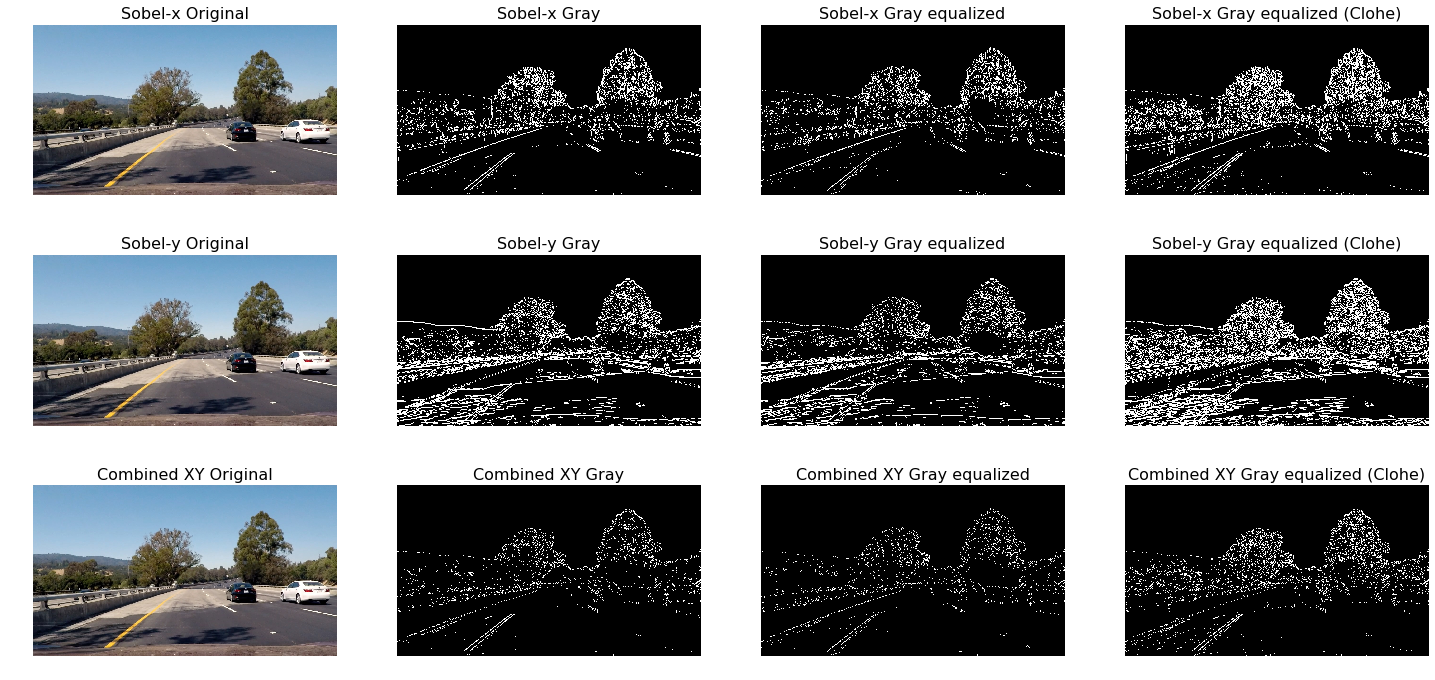

In [38]:
# Apply Sobel
from lanelines.preprocessing import Sobel, scale
import numpy as np

sobels_x = [threshold(scale(Sobel(img, orientation="x", sobel_kernel=3)), thresh=[20, 100]) for img in [imgs_gray0[4],imgs_gray1[4], imgs_gray2[4] ]]
sobels_y = [threshold(scale(Sobel(img, orientation="y", sobel_kernel=3)), thresh=[20, 100]) for img in [imgs_gray0[4],imgs_gray1[4], imgs_gray2[4] ]]

combined = np.zeros_like(sobels_x)
for i in range(len(sobels_x)):
    combined[i][(sobels_x[i] == 1) & (sobels_y[i] == 1)] = 1

plot_images(["Sobel-x", "Sobel-y", "Combined XY"], ["Original", "Gray", "Gray equalized", "Gray equalized (Clohe)"], [test_imgs[4],test_imgs[4],test_imgs[4]], [sobels_x[0], sobels_y[0], combined[0]], [sobels_x[1], sobels_y[1], combined[1]], [sobels_x[2], sobels_y[2], combined[2]])


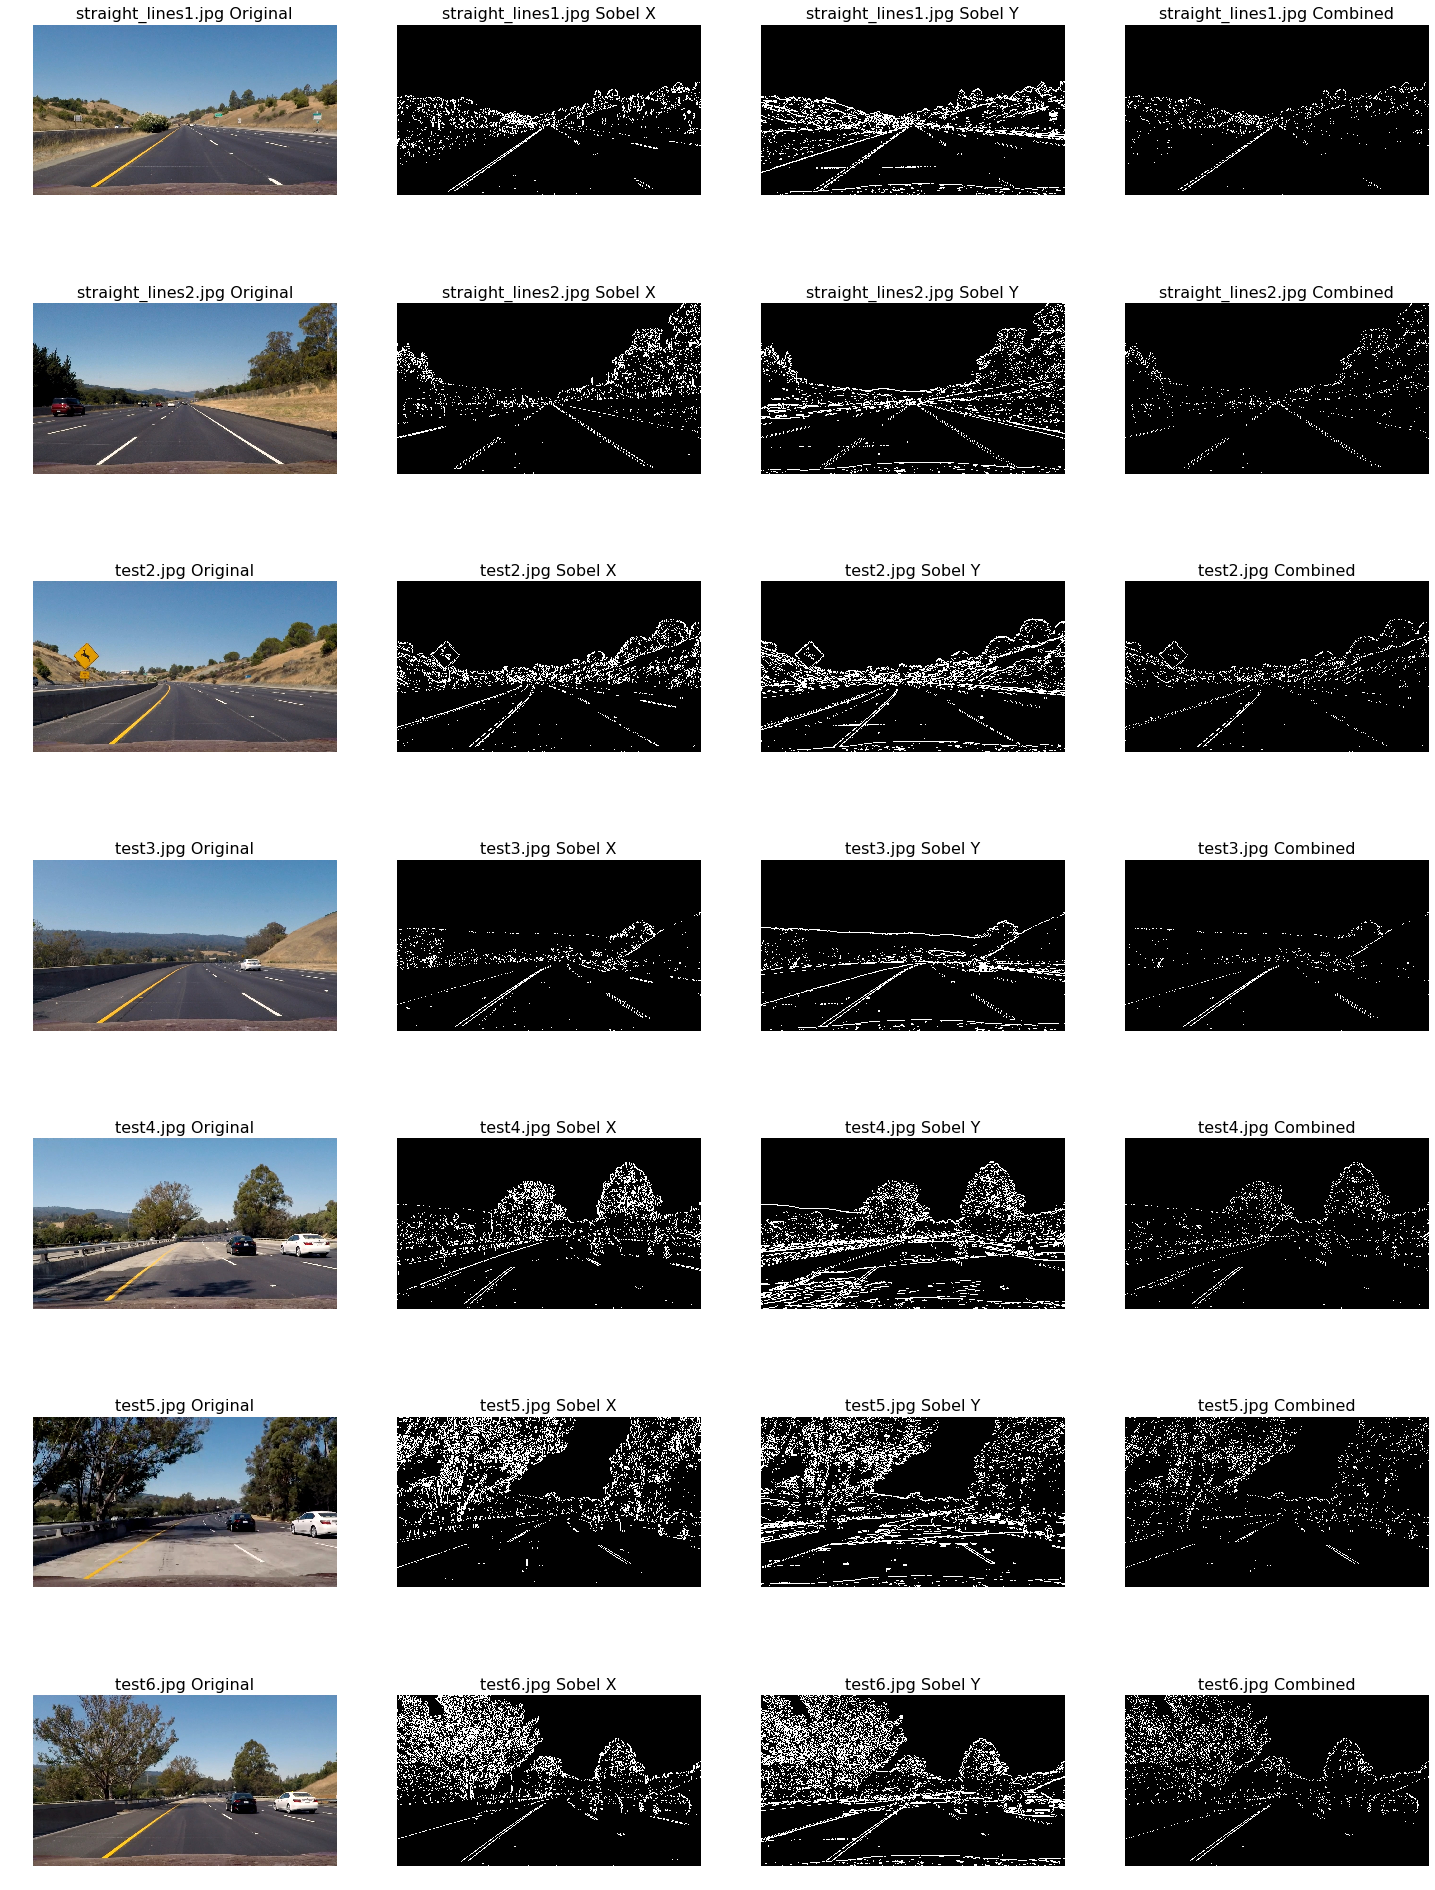

In [42]:
# Apply Sobel
from lanelines.preprocessing import Sobel, scale
import numpy as np

sobels_x = [threshold(scale(Sobel(img, orientation="x", sobel_kernel=3)), thresh=[20, 100]) for img in imgs_gray0]
sobels_y = [threshold(scale(Sobel(img, orientation="y", sobel_kernel=3)), thresh=[20, 100]) for img in imgs_gray0]
combined = np.zeros_like(sobels_x)
for i in range(len(sobels_x)):
    combined[i][(sobels_x[i] == 1) & (sobels_y[i] == 1)] = 1
plot_images(fnames, ["Original", "Sobel X", "Sobel Y", "Combined"], test_imgs, sobels_x, sobels_y, combined)

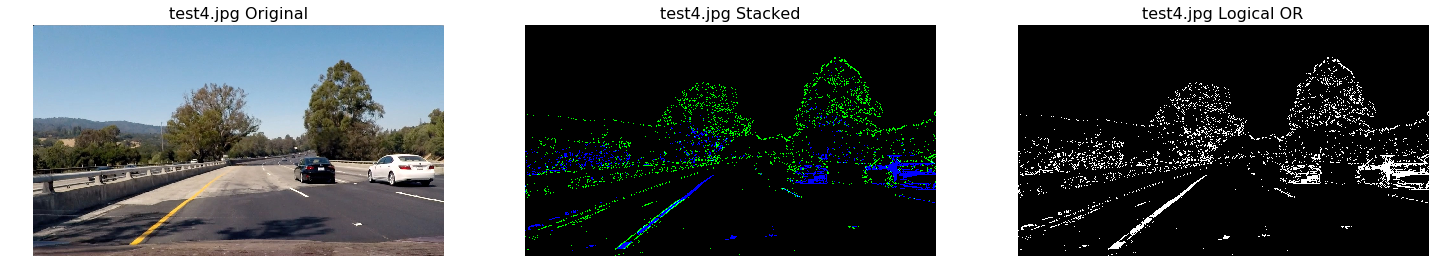

In [44]:
# Stacked images
color_binary = np.zeros_like(test_imgs)
for i in range(len(sobels_x)):
    color_binary[i] = np.dstack(( np.zeros_like(combined[i]), combined[i], s_imgs_thrsh[i])) * 255

# Final images
combined_final = np.zeros_like(s_imgs_thrsh)
for i in range(len(sobels_x)):
    combined_final[i][(combined[i] == 1) | (s_imgs_thrsh[i] == 1)] = 1

plot_images(fnames[4:5], ["Original", "Stacked", "Logical OR"], test_imgs[4:5], color_binary[4:5], combined_final[4:5])

## Perspective Transformation

(<matplotlib.axes._subplots.AxesSubplot at 0x1c34947c18>,
 <matplotlib.image.AxesImage at 0x1c28cb47b8>)

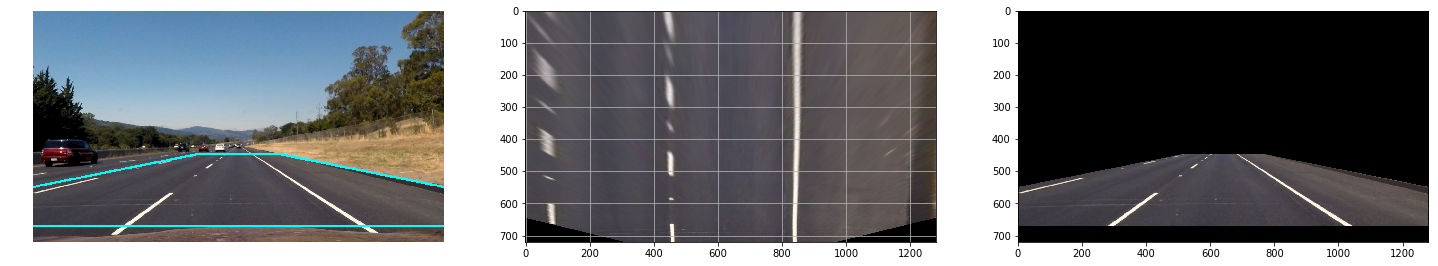

In [82]:
from lanelines.preprocessing import init_birdeye, image2birdeye, birdeye2image
from lanelines.decorator import trapezoid

# Initialize the perspective transformation
_config = init_birdeye()

# Decorated original image
target_pic = undistorted_imgs[1]
decorated_img = trapezoid(target_pic, _config.src)

# Warped image
warped_img = image2birdeye(target_pic, _config)

# Unwarped image
unwarped_img = birdeye2image(warped_img, _config)

# Create a plot
plt.figure(figsize=(25,20))
plt.subplot(1,3,1), plt.axis("off"), plt.imshow(decorated_img)
plt.subplot(1,3,2), plt.grid(which="both"), plt.imshow(warped_img, cmap="gray")
plt.subplot(1,3,3), plt.imshow(unwarped_img, cmap="gray")


In [48]:
print("src", _config.src)
print("dst", _config.dst)

src [[ 515.  445.]
 [ 765.  445.]
 [1890.  670.]
 [-610.  670.]]
dst [[   0.    0.]
 [1280.    0.]
 [1280.  720.]
 [   0.  720.]]


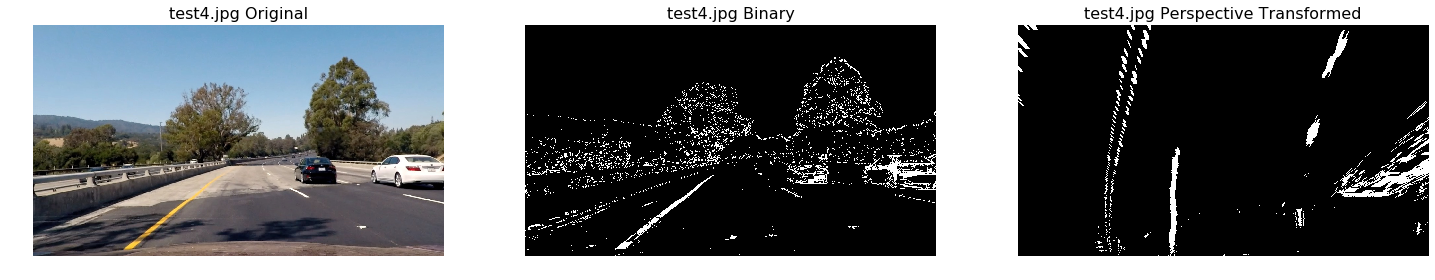

In [52]:
from lanelines.preprocessing import init_birdeye, image2birdeye

perspective_transf = [image2birdeye(img, _config) for img in combined_final]
plot_images(fnames[4:5], ["Original", "Binary", "Perspective Transformed"], undistorted_imgs[4:5], combined_final[4:5], perspective_transf[4:5])

## Lane Initialization

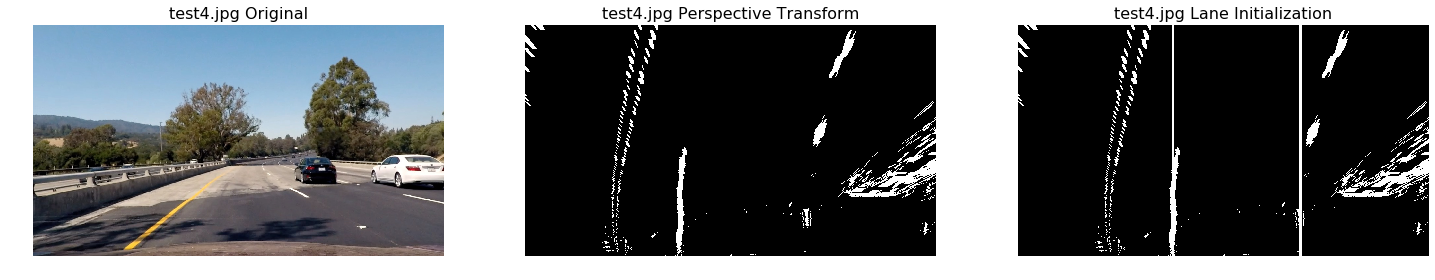

In [53]:
from lanelines.detection import init_lane_lines

lanes = [init_lane_lines(img)[2] for img in perspective_transf]
plot_images(fnames[4:5], ["Original", "Perspective Transform", "Lane Initialization"], undistorted_imgs[4:5],perspective_transf[4:5], lanes[4:5])

## Detect Lane Lines (Sliding Window)

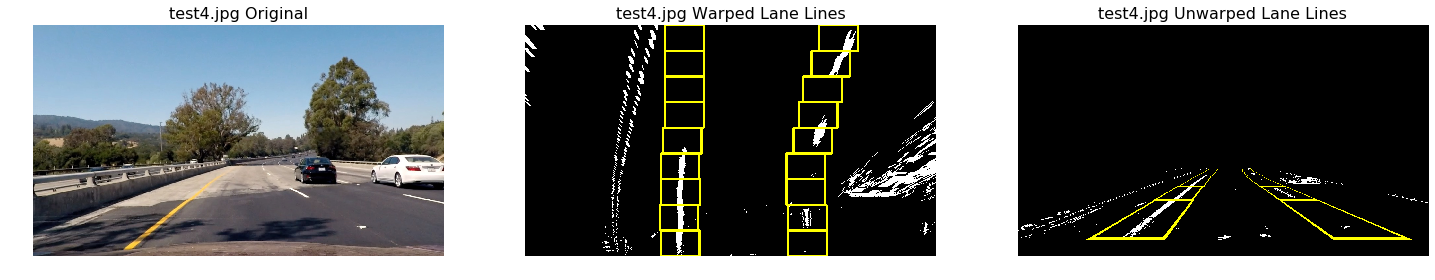

In [64]:
from lanelines.detection import init_lane_lines, search_sliding_window
from lanelines.preprocessing import image2birdeye

results_warped = []
results_unwarped = []
for img_id in range(len(test_imgs)):
    leftx, lefty, rightx, righty, out_img = search_sliding_window(perspective_transf[img_id])
    results_warped.append(out_img)
    results_unwarped.append(birdeye2image(out_img, _config))
plot_images(fnames[4:5], ["Original", "Warped Lane Lines", "Unwarped Lane Lines"], undistorted_imgs[4:5], results_warped[4:5], results_unwarped[4:5])

## Detect Lane Lines (Polygon Search)

RESETTING SEARCH
RESETTING SEARCH
RESETTING SEARCH
RESETTING SEARCH
RESETTING SEARCH
RESETTING SEARCH
RESETTING SEARCH


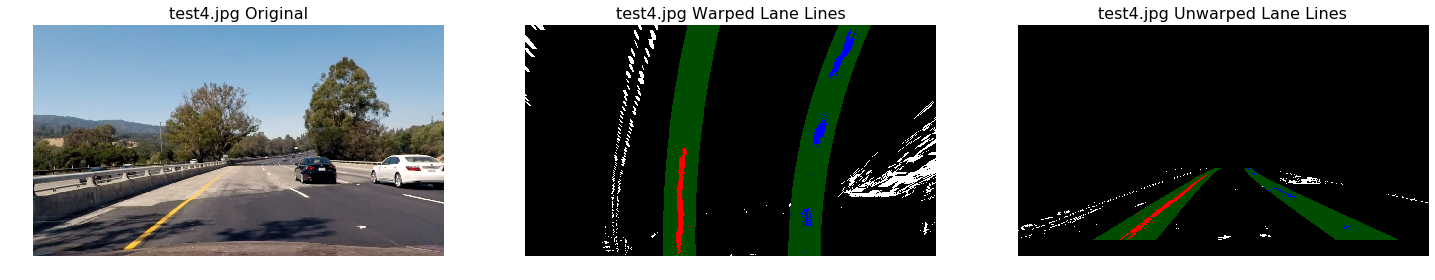

In [65]:
from lanelines.detection import init_lane_lines, search_sliding_window
from lanelines.preprocessing import image2birdeye

results_warped = []
results_unwarped = []
for img_id in range(len(test_imgs)):
    out_img, lane_history = fit_polynomial(perspective_transf[img_id])
    _, _, _, _, out_img_poly = search_around_poly(np.copy(perspective_transf[img_id]), lane_history)
    results_warped.append(out_img_poly)
    results_unwarped.append(birdeye2image(out_img_poly, _config))
plot_images(fnames[4:5], ["Original", "Warped Lane Lines", "Unwarped Lane Lines"], undistorted_imgs[4:5], results_warped[4:5], results_unwarped[4:5])

## Polygon overlay
I put a polygon on each found image to mark the lane lines

RESETTING SEARCH
RESETTING SEARCH
RESETTING SEARCH
RESETTING SEARCH
RESETTING SEARCH
RESETTING SEARCH
RESETTING SEARCH


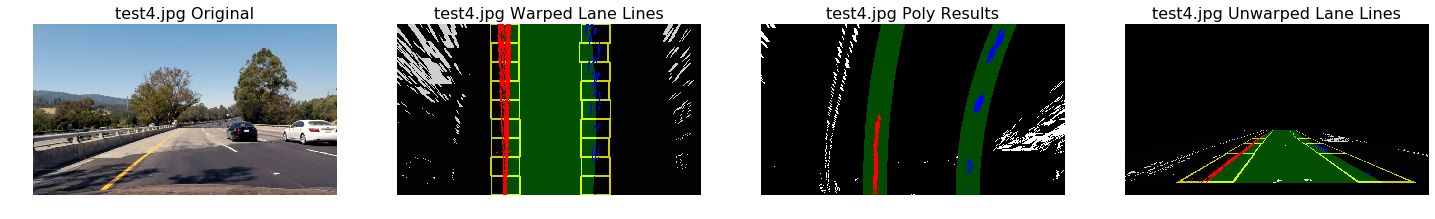

In [122]:
from lanelines.detection import fit_polynomial, init_lane_lines, measure_curvature_pixels, measure_offset_pixels, search_around_poly
from lanelines.preprocessing import image2birdeye

results_warped = []
results_unwarped = []
poly_results = []
curvatures = []
offsets = []
for img_id in range(len(test_imgs)):
    out_img, lane_history = fit_polynomial(perspective_transf[img_id])
    
    _, _, _, _, out_img_poly = search_around_poly(np.copy(perspective_transf[img_id]), lane_history)
    poly_results.append(out_img_poly)
    
    curverad = measure_curvature_pixels(_config.h, lane_history)
    offset = measure_offset_pixels(lane_history, _config)
    curvatures.append(curverad)
    offsets.append(offset)
    results_warped.append(out_img)
    results_unwarped.append(birdeye2image(out_img, _config))
plot_images(fnames[4:5], ["Original", "Warped Lane Lines", "Poly Results", "Unwarped Lane Lines"], undistorted_imgs[4:5], results_warped,poly_results[4:5], results_unwarped[4:5])

## Unwarp images

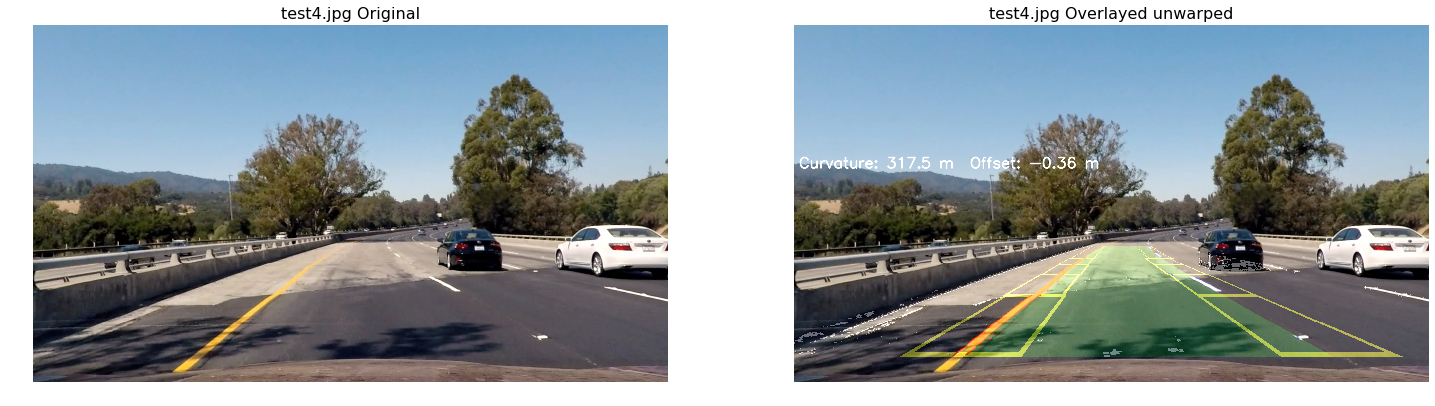

In [123]:
from lanelines.decorator import weighted_img, text_on_image
overlayed_unwarped = []
for img_id in range(len(test_imgs)):
    target = weighted_img(undistorted_imgs[img_id], results_unwarped[img_id], α=0.5, β=1., γ=0.)
    target = text_on_image(target, curvatures[img_id], offsets[img_id])
    overlayed_unwarped.append(target)
    
plot_images(fnames[4:5], ["Original", "Overlayed unwarped"], undistorted_imgs[4:5], overlayed_unwarped[4:5])

## Final Pipeline

RESETTING SEARCH


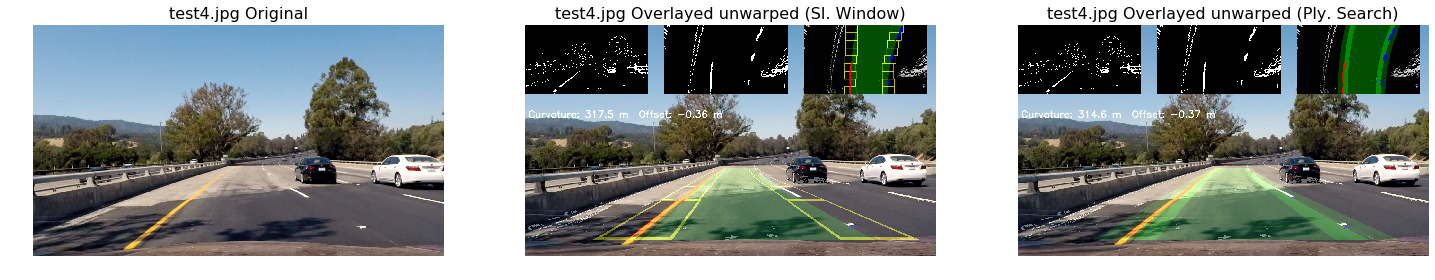

In [124]:
from lanelines.pipeline import transform_img

pipeline_result, lane_history = transform_img(test_imgs[4], dist_cor, _config)
pipeline_result2, lane_history = transform_img(test_imgs[4], dist_cor, _config, lane_history)
plot_images(fnames[4:5], ["Original", "Overlayed unwarped (Sl. Window)", "Overlayed unwarped (Ply. Search)"], undistorted_imgs[4:5], [pipeline_result],[pipeline_result2])

In [126]:
from lanelines.pipeline import transform_vid
transform_vid('project_video.mp4')
#transform_vid('challenge_video.mp4')
#transform_vid('harder_challenge_video.mp4')

['/Users/philippmarcus/udacity/sdcnd/CarND-Advanced-Lane-Lines/data/raw/test_videos/project_video.mp4']
Successfully calibrated DistortionCorrector.


t:   0%|          | 2/1260 [00:00<01:33, 13.53it/s, now=None]

RESETTING SEARCH
Moviepy - Building video /Users/philippmarcus/udacity/sdcnd/CarND-Advanced-Lane-Lines/data/processed/video_output/project_video.mp4.
Moviepy - Writing video /Users/philippmarcus/udacity/sdcnd/CarND-Advanced-Lane-Lines/data/processed/video_output/project_video.mp4



Moviepy - Done !
Moviepy - video ready /Users/philippmarcus/udacity/sdcnd/CarND-Advanced-Lane-Lines/data/processed/video_output/project_video.mp4
